In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection  import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
%matplotlib inline

# Objective
This data set from Kaggle contains tweets about COVID19 vaccines with lists of Hashtags. The goal of this project is classifying these tweets to distinguish health-oriented, political and superstition based on NLP algorithms.

In order to achieve this, we follow three steps:

    1.	Text processing and data preparation: in this step we format the data, delete GDPR related information, extract links from tweets and checking some data features
    
    2.	Assigning categories: this is semi-manual process which plays a role in the prediction quality. We have to classify the tweets directly one-by-one, which is a manual time-consuming process but will generate higher precision the end.
        
    
    Approval             |  177  | %7.48 
    Business             |   32  | %1.35 
    Health               |   73  | %3.09 
    Junk Knowledge       |  102  | %4.31 
    Other                |   64  | %2.70 
    Politics             |   70  | %2.96 
    Shipment             |  110  | %4.65 
    Unique vaccination   |  153  | %6.47 
    Vaccination campaign |  95   | %4.02 
    Vaccine              |  130  | %5.49 
    Vaccine reactions    |  59   | %2.49 

    Unclassified         | 1.360 | %57.48 
    

    3.	Once categories are assigned, an NLP vectorizer is used to predict the tweets.

At the end we will have a classifier to predict whether the tweet has real informative value in regards to COVID19 and helps to eliminate all junk-science or any other irrelevant information.


## 1. Data Pre-processing

In [24]:
# Read data
twitter_data = pd.read_excel('vaccination_tweets.xlsx',sheet_name='vaccination_tweets')

In a first steps all countries were normalised as a potential feature, for the moment the geographical location is not used:

In [25]:
twitter_data['Country'].fillna('NA',inplace=True)
nb_countries = len(twitter_data['Country'].unique())
freq=pd.DataFrame(twitter_data['Country'].value_counts())
freq.reset_index(inplace=True)
freq.columns = ['Country','Country_freq']
twitter_data  = twitter_data.merge(freq,how='left',on='Country')

The text contains both the tweet and the link to this tweet, we separate both in order to (1) remove noise made by the link (2) make it easier later to check the tweets:

In [26]:
def link_extractor(text):
    if '¦' in text:
        return text.split('¦')[1].strip()
    else:
        return ""
def text_extractor(text):
    if '¦' in text:
        return text.split('¦')[0].strip()
    else:
        return text.strip()

twitter_data['link'] = twitter_data['text'].apply(lambda t:link_extractor(t))
twitter_data['text'] = twitter_data['text'].apply(lambda t:text_extractor(t))

The table contains data related to the users. As we do not need these columns, it is better to get rid of these data for privacy reasons:

In [27]:
#GDPR filters
del twitter_data['id']
del twitter_data['user_name']
del twitter_data['user_description']

Another feature that is not used for the moment is the text length:

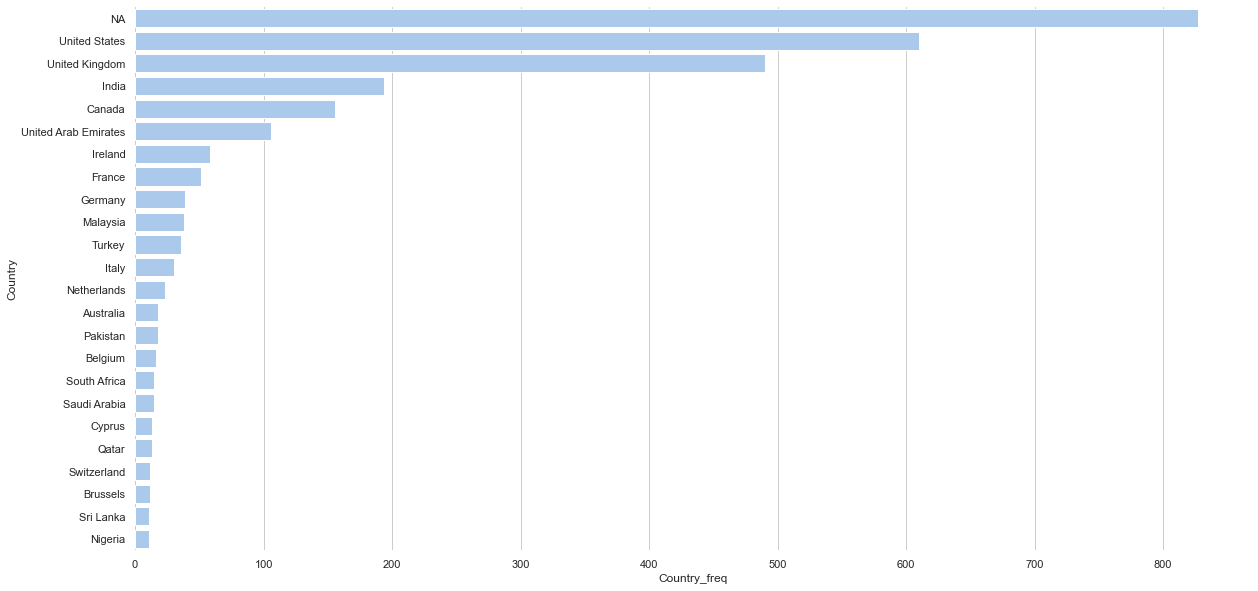

In [28]:
sns.set_palette("GnBu_d")
sns.set(style="whitegrid")
# Load the example car crash dataset
twitter_data_sample = twitter_data[twitter_data['Country_freq']>10].sort_values("Country_freq", ascending=False)

plt.figure(figsize=(20,10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Country_freq", y='Country', data=twitter_data_sample,
            label="Total", color="b")


sns.despine(left=True, bottom=True)

<AxesSubplot:>

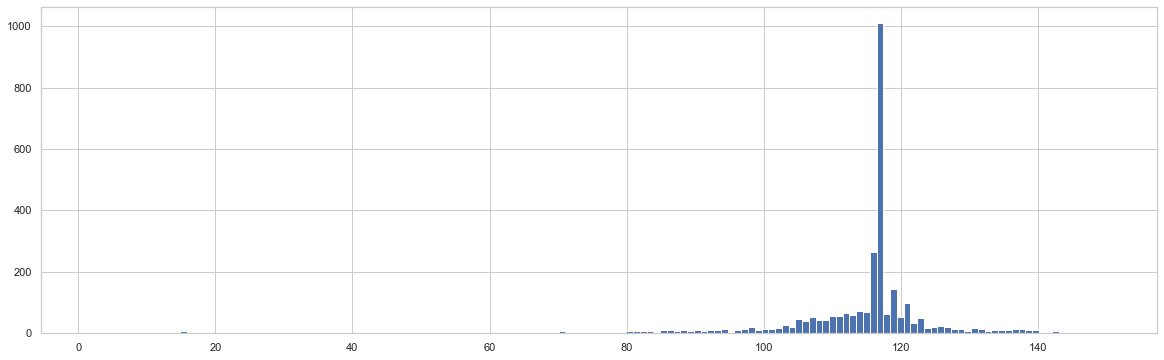

In [29]:
twitter_data['text_length'] = twitter_data['text'].apply(lambda t:len(t))
twitter_data['text_length'].hist(bins=150,figsize=(20,6))

In [30]:
"""twitter_data.to_excel("vaccination_tweets_processed_.xlsx",sheet_name='data processed')
twitter_data.head(10)"""

'twitter_data.to_excel("vaccination_tweets_processed_.xlsx",sheet_name=\'data processed\')\ntwitter_data.head(10)'

## 2. Assigning Hashtags

In this step we are going to extract and format hashtags in order to classify the tweets into categories. The first step is to extract all the hashtags and perform statistical occurences counts.

In [31]:
# All unique hashtags are extracted in a seperate list
hashtags = []
for element in  twitter_data['hashtags'].fillna("").unique():
        for hashtag in element.replace("[","").replace("]","").replace("'","").split(','):
            if not hashtag.strip().lower() in hashtags and not (hashtag==""):
                hashtags.append(hashtag.strip().lower())
hashtags = pd.DataFrame(hashtags, columns = ['Hashtags'])
hashtags["Frequency"] = 0

In [32]:
# A count on the hashtags occurences is made
def count_hashtag(row):
    if type (row ) == float:
        row=str(row)
    values = row.replace("[","").replace("]","").replace("'","").split(',')
    for value in values:
        hashtags.loc[hashtags['Hashtags']==value.strip().lower(),'Frequency'] +=1

twitter_data['hashtags'].apply(lambda values:count_hashtag(values))
hashtags.sort_values('Frequency', axis=0, ascending=False, inplace=True)

In [33]:
# The ratio of the hashtags is also added as additonal informnation
hashtags.reset_index(inplace = True)
if 'index' in hashtags.columns:
    del hashtags['index']
total_occurencies = hashtags["Frequency"].sum()
hashtags['frequencies_ratio'] = float(0)
l = len(hashtags.index)
for i in range(0,l):
    sub_total = 0
    if i<l:
        sub_total = hashtags["Frequency"][0:i+1].sum()
    else:
        sub_total = total_occurencies
    ratio = float(sub_total/total_occurencies)
    hashtags.iloc[i,hashtags.columns.get_loc('frequencies_ratio')] = ratio
hashtags.sort_values('frequencies_ratio', axis=0, inplace=True)

In this step we add a priority column to manually create hashtags: the first ones appearing on most of the tweets should be excluded to avoid the biased results, the other ones in the long-tail should also be deprioritised as they would make the manual effort longer:

<ipython-input-34-b8299fd63f3e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags[start:end]['Include hashtag'] = 'Yes'


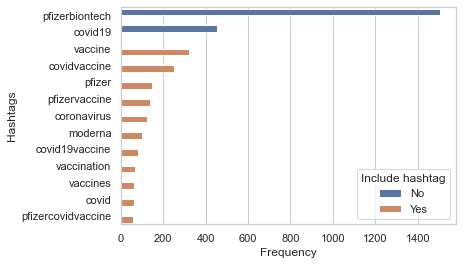

In [34]:
hashtags['Include hashtag'] = 'No'
threshold = 0.6
strat = 2
start = hashtags.iloc[strat,hashtags.columns.get_loc('frequencies_ratio')]
end = len(hashtags[hashtags['frequencies_ratio']<threshold].index)
hashtags.set_index('frequencies_ratio',inplace=True)
hashtags[start:end]['Include hashtag'] = 'Yes'
hashtags.reset_index(inplace = True)
ax = sns.barplot(x='Frequency', y='Hashtags', data=hashtags[0:end],hue='Include hashtag')

Both the data and the hashtags count are then saved for manual classification:

In [35]:
writer = pd.ExcelWriter('vaccination_tweets_processed_.xlsx')
twitter_data.to_excel(writer,'data processed',index=False)
pd.DataFrame(hashtags).to_excel(writer,'Hashtags frequency',index=False)
writer.save()

After performing manual classification (STILL IN PRGRESS) the hashtags are read again to elect a Category for tweets that are still without categories:

In [36]:
hashtags = pd.read_excel('vaccination_tweets_processed.xlsx',sheet_name='Hashtags')
cat = pd.DataFrame(pd.read_excel('vaccination_tweets_processed.xlsx',sheet_name='data processed')['Category'].fillna(''),columns =['Category'])
twitter_data = pd.concat([twitter_data,cat],axis=1)

In [37]:
twitter_data

,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Country,Country_freq,link,text_length,Category
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,United States,610,,97,Junk Knowledge
1,"San Francisco, CA",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,United States,610,https://t.co/dlCHrZjkhm,117,Shipment
2,Your Bed,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NA,827,https://t.co/ieYlCKBr8P,117,Vaccine
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,Canada,156,https://t.co/jqgV18kch4,117,Vaccine
4,NaN,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NA,827,https://t.co/KxbSRoBEHq,112,Junk Knowledge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,Everywhere,2021-01-02 22:28:50,16,121,0,False,2021-01-02 22:36:45,Countries that have approved the #PfizerBioNTe...,['PfizerBioNTech'],Twitter for iPhone,0,0,False,NA,827,Canada\nðŸ‡²ðŸ‡½ Mexico\nðŸ‡®ðŸ‡± Israelâ€,98,Approval
2974,Earth,2018-04-17 03:48:35,22,90,2779,False,2021-01-02 22:20:01,Vaccinated! Got my first dose. \n#PfizerBioNT...,"['PfizerBioNTech', 'vaccine']",Twitter for iPhone,0,2,False,NA,827,,58,
2975,Canterbury,2009-02-05 11:27:29,1966,1192,4617,False,2021-01-02 22:13:43,Astounding behind the scenes film. The Pfizer ...,NaN,Twitter for iPhone,0,2,False,United Kingdom,490,https://t.co/W3omGYaYTv,117,
2976,NaN,2013-05-06 03:26:53,904,985,12118,False,2021-01-02 22:06:12,@JD24 OMG congratulations ðŸ˜· #vaccine #Pfize...,"['vaccine', 'PfizerBioNTech']",Twitter for iPhone,0,1,False,NA,827,,60,


In [38]:
twitter_data['Category'].unique()

array(['Junk Knowledge', 'Shipment', 'Vaccine', 'Health', 'Politics',
       'Vaccination campaign', 'Business', 'Other', 'Approval',
       'Unique vaccination', 'Vaccine reactions', ''], dtype=object)

# 3. NLP Classification

The first step is selecting the tweets that have been classified:

In [39]:
twitter_data_sample = twitter_data[twitter_data['Category'] != ''].reset_index()
del twitter_data_sample['index']
twitter_data_sample

,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Country,Country_freq,link,text_length,Category
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,United States,610,,97,Junk Knowledge
1,"San Francisco, CA",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,United States,610,https://t.co/dlCHrZjkhm,117,Shipment
2,Your Bed,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NA,827,https://t.co/ieYlCKBr8P,117,Vaccine
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,Canada,156,https://t.co/jqgV18kch4,117,Vaccine
4,NaN,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NA,827,https://t.co/KxbSRoBEHq,112,Junk Knowledge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,NaN,2020-11-10 09:53:32,2,0,0,False,2021-01-03 13:50:40,WHO approved for Pfizer-BioNTech vaccine\n\nRe...,"['WHO', 'PfizerVaccine', 'Pfizer']",Twitter Web App,0,0,False,NA,827,https://t.co/IPXYLUdExi,109,Approval
1061,Srinagar - Montreal,2013-08-18 18:06:00,109,153,26005,False,2021-01-03 13:14:55,"So, why don't have you approved #PfizerBioNTec...","['PfizerBioNTech', 'US', 'UK', 'EU']",Twitter Web App,0,0,False,Canada,156,https://t.co/cnB18ANXQM,124,Approval
1062,NaN,2020-06-07 08:43:13,3,44,5,False,2021-01-03 12:10:47,India approves AstraZeneca and Bharat Biotech ...,NaN,TweetDeck,0,0,False,NA,827,https://t.co/otntxoF7ly,117,Approval
1063,Everywhere,2021-01-02 22:28:50,16,121,0,False,2021-01-02 22:36:45,Countries that have approved the #PfizerBioNTe...,['PfizerBioNTech'],Twitter for iPhone,0,0,False,NA,827,Canada\nðŸ‡²ðŸ‡½ Mexico\nðŸ‡®ðŸ‡± Israelâ€,98,Approval


In [40]:
def text_cleaner(text):
    """ This function aims at removing links, tagged names and and '#' characters from the text values as they
    do not have real value and add noise to the text
    """
    new_text = []
    text = text.split(' ')
    for element in text:
        add_text = True
        if 'https' in element:
            add_text = False
        if '@' in element:
            add_text = False
        if '#' in element:
            add_text = False
        if add_text:
            new_text.append(element)
    return ' '.join(new_text)

twitter_data_sample['text'] = twitter_data_sample['text'].apply(lambda s:text_cleaner(s))
twitter_data_sample

,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Country,Country_freq,link,text_length,Category
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,United States,610,,97,Junk Knowledge
1,"San Francisco, CA",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,United States,610,https://t.co/dlCHrZjkhm,117,Shipment
2,Your Bed,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 yearsâ€,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NA,827,https://t.co/ieYlCKBr8P,117,Vaccine
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,Canada,156,https://t.co/jqgV18kch4,117,Vaccine
4,NaN,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NA,827,https://t.co/KxbSRoBEHq,112,Junk Knowledge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,NaN,2020-11-10 09:53:32,2,0,0,False,2021-01-03 13:50:40,WHO approved for Pfizer-BioNTech vaccine\n\nRe...,"['WHO', 'PfizerVaccine', 'Pfizer']",Twitter Web App,0,0,False,NA,827,https://t.co/IPXYLUdExi,109,Approval
1061,Srinagar - Montreal,2013-08-18 18:06:00,109,153,26005,False,2021-01-03 13:14:55,"So, why don't have you approved which &amp; ha...","['PfizerBioNTech', 'US', 'UK', 'EU']",Twitter Web App,0,0,False,Canada,156,https://t.co/cnB18ANXQM,124,Approval
1062,NaN,2020-06-07 08:43:13,3,44,5,False,2021-01-03 12:10:47,India approves AstraZeneca and Bharat Biotech ...,NaN,TweetDeck,0,0,False,NA,827,https://t.co/otntxoF7ly,117,Approval
1063,Everywhere,2021-01-02 22:28:50,16,121,0,False,2021-01-02 22:36:45,Countries that have approved the COVID-19 vacc...,['PfizerBioNTech'],Twitter for iPhone,0,0,False,NA,827,Canada\nðŸ‡²ðŸ‡½ Mexico\nðŸ‡®ðŸ‡± Israelâ€,98,Approval


Defining text filtering function

In [41]:
def text_process(mess):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of cleantext words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Importing NLP libraries:

In [42]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
bow_transformer = CountVectorizer(analyzer = text_process).fit(twitter_data_sample['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\waelj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creating the IfIDF matrix

In [43]:
messages_bow = bow_transformer.transform(twitter_data_sample['text'])
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

Finally, we predict the tweets Category using a MultinomialNB classifier

In [44]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,twitter_data_sample['Category'])
msg_train,msg_test,label_train,label_test = train_test_split(twitter_data_sample['text'],twitter_data_sample['Category'],test_size=0.3)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer = text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])
pipeline.fit(msg_train,label_train)
precitions = pipeline.predict(msg_test)
print(classification_report(label_test,precitions))


                      precision    recall  f1-score   support

            Approval       0.35      0.93      0.51        56
            Business       0.00      0.00      0.00         7
              Health       1.00      0.23      0.37        22
      Junk Knowledge       1.00      0.13      0.23        38
               Other       0.00      0.00      0.00        13
            Politics       0.00      0.00      0.00        21
            Shipment       0.54      0.59      0.57        22
  Unique vaccination       0.38      0.91      0.54        47
Vaccination campaign       0.67      0.12      0.21        33
             Vaccine       0.46      0.12      0.19        49
   Vaccine reactions       0.83      0.42      0.56        12

            accuracy                           0.42       320
           macro avg       0.48      0.31      0.29       320
        weighted avg       0.51      0.42      0.33       320



C:\Users\waelj\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The predictions results are not satisfying for the moment but have improved along the classification efforts (still in progress), the tweets complete classification should play a role in improving the results.